# (6) Understanding CPD Emission

At this point, we've developed the code far enough to see the residual emission that might be associated with any circumplanetary disk (CPD) in the SR 4 disk gap.  After this part, we will develop the code that statistically vets those residuals.  But first, it would be helpful to get a better understanding of what we might actually expect from a CPD based on some theoretical models.  

So far, you've breezed through most of the coding exercises as I've set them up.  But here I'm going to give you some more "license" to explore on your own.  Please read through [this article](https://ui.adsabs.harvard.edu/abs/2018MNRAS.479.1850Z/abstract) on simple CPD emission models at mm/radio wavelengths.  The goal of this part is to write some code that follows the methodology laid out in Section 2, to the point where you can reproduce Figures 1 and 2.  This will give us the infrastructure to compare what we can extract from the data to a theoretical basis at the end of the summer, and it will also give you a better idea about typical mm-wavelength emission properties of CPDs that will guide us in developing the statistical vetting approach in the subsequent parts of the project.

Text(0, 0.5, 'log(T / K)')

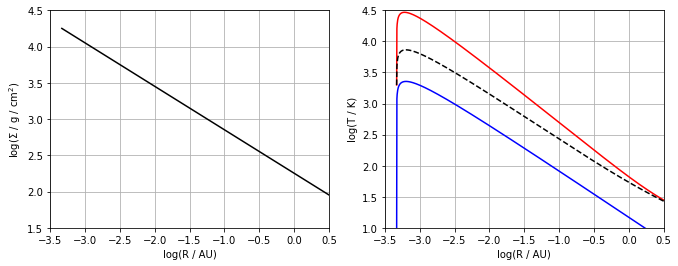

In [68]:
import os, sys, time           
import numpy as np             
import matplotlib.pyplot as plt
%matplotlib inline               
import math

# input parameters
R_in = 1.0    # inner edge of CPD in Rjup units
R_out = 1.85  # outer edge of CPD in AU
R_p = 1.0     # planet radius in Rjup units
M_p = 1.0     # planet mass in Mjup
Mdot = 1e-5   # planetary accretion rate in Mjup / yr
alpha = 0.001 # turbulence coefficient (dimension-less)
wl = 0.85     # wavelength in mm
dpc = 140.    # distance in pc


# constants (cgs units)
G = 6.67e-8        # cm**2 / g / s**2
kB = 1.3801e-16    # erg / K
sigSB = 5.67e-5    # erg / cm**2 / s / K**4
mu = 2.4           # 1 / mol
Rg = 8.3145e7      # erg / K / mol
AU = 1.496e13      # cm
Msun = 1.989e33    # g
Mjup = 1.898e30    # g
Rjup = 6.9911e9    # cm
yr = 3.154e7       # s

# radius grid
Rau = np.logspace(np.log10(R_in * Rjup / AU), 0.5, 1000)
R = Rau * AU
        
# opacities
kappa_mm = 0.034 * (0.87 / wl)
kappa_r = 10.                      
    
# Eq 1: effective temperature: Teff**4 (K**4)
Teff4 = 3 * G * (M_p * Mjup) * (Mdot * Mjup / yr) * (1 - (R[0] / R)**0.5) / (8 * np.pi * sigSB * R**3)
Teff4 = np.clip(Teff4, 5**4, 10000**4)
    
# Eq 3: irradiation temperature
Lirr = G * (M_p * Mjup) * (Mdot * Mjup / yr) / (2 * R_p * Rjup)
Tirr4 = Lirr / (40 * np.pi * R**2 * sigSB)
    
# external temperature
Tism = 10.
Text4 = Tirr4 + Tism**4
    
# Eq 6: sigma
sig_eq6 = (2**1.4 / 3**1.2) * (sigSB * G * (M_p * Mjup) * (Mdot * Mjup / yr)**3 / \
          (alpha**4 * np.pi**3 * kappa_r * R**3))**0.2 * (mu / Rg)**0.8 #* (1 - (R[0] / R)**0.5)**0.6
        
# Eq 7: sigma
omega = np.sqrt(G * (M_p * Mjup) / R**3)
sig_eq7 = (Mdot * Mjup / yr) * mu * omega / (3 * np.pi * alpha * Rg * Text4**0.25)
    
# sigma (note that Fig 1 is for viscous heating models, which means Eq 6 for sigma [see caption])
#sigma = np.minimum(sig_eq6, sig_eq7)
sigma = sig_eq6

# Eq 4: midplane temperature: Tc**4
Tc4 = 9 * G * (M_p * Mjup) * (Mdot * Mjup / yr) * sigma * kappa_r * (1 - (R[0] / R)**0.5) / \
      (128 * np.pi * sigSB * R**3) + Text4


# mm optical depths
tau_mm = kappa_mm * sigma / 2

# Eq 8: brightness temperatures
Tb = ((3 * kappa_r / (8 * kappa_mm)) * Teff4 + Text4)**0.25
Tb[tau_mm < 0.5] = 2 * Tc4[tau_mm < 0.5]**0.25 * tau_mm[tau_mm < 0.5]


# plot like top panels of Fig 1
fig, axs = plt.subplots(ncols=2, figsize=(11,4))

ax = axs[0]
ax.plot(np.log10(Rau), np.log10(sigma), 'k')
ax.grid()
ax.set_xlim([-3.5, 0.5])
ax.set_ylim([1.5, 4.5])
ax.set_xlabel('log(R / AU)')
ax.set_ylabel('log($\Sigma$ / g / cm$^2$)')

ax = axs[1]
ax.plot(np.log10(Rau), np.log10(Tc4**0.25), 'r')
ax.plot(np.log10(Rau), np.log10(Teff4**0.25), 'b')
ax.plot(np.log10(Rau), np.log10(Tb), '--k')
ax.grid()
ax.set_xlim([-3.5, 0.5])
ax.set_ylim([1.0, 4.5])
ax.set_xlabel('log(R / AU)')
ax.set_ylabel('log(T / K)')

Text(0, 0.5, 'log(F / $\\mu$Jy)')

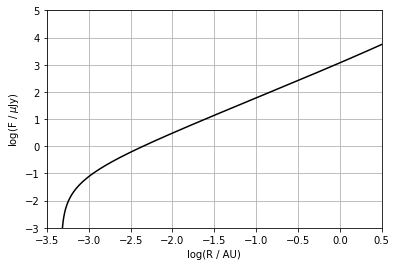

In [69]:
from scipy.integrate import cumtrapz

# surface brightness profile (Jy per arcsec**2)
Inu = 1e23 * 2 * kB * Tb / (wl * 0.1)**2 / (180 * 3600 / np.pi)**2

# integrate to get flux as a function of outer radius
flux = cumtrapz(2 * np.pi * (Rau / dpc) * Inu, (Rau / dpc), initial=1e-50)

# reproduce Fig 2 (for 0.85 mm wavelength only)
fig, ax = plt.subplots()
ax.plot(np.log10(Rau), np.log10(1e6*flux), 'k')
ax.grid()
ax.set_xlim([-3.5, 0.5])
ax.set_ylim([-3, 5])
ax.set_xlabel('log(R / AU)')
ax.set_ylabel('log(F / $\mu$Jy)')